In [1]:
# Détecteur d'Intrusion Réseau par IA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

print("Bibliothèques importées avec succès")

# Chargement du dataset
df = pd.read_csv(r"E:\IDS_Project\Datasets\dataset_ids.csv")

print(f"Dataset chargé")
print(f"   Lignes   : {len(df):,}")
print(f"   Colonnes : {df.shape[1]}")
print(f"\nAperçu des données :")
print(df.head())
print(f"\nRépartition des classes :")
print(df['label'].value_counts())

Bibliothèques importées avec succès
Dataset chargé
   Lignes   : 3,147,059
   Colonnes : 9

Aperçu des données :
  protocol          ip_src          ip_dst  port_src  port_dst  packet_length  \
0      TCP  192.168.100.20  192.168.100.10     55754        22             74   
1      TCP  192.168.100.10  192.168.100.20        22     55754             74   
2      TCP  192.168.100.20  192.168.100.10     55754        22             66   
3      TCP  192.168.100.20  192.168.100.10     55754        22             99   
4      TCP  192.168.100.10  192.168.100.20        22     55754             66   

      timestamp  ttl   label  
0  1.771716e+09   64  normal  
1  1.771716e+09   64  normal  
2  1.771716e+09   64  normal  
3  1.771716e+09   64  normal  
4  1.771716e+09   64  normal  

Répartition des classes :
label
dos       3144212
nmap         2001
normal        846
Name: count, dtype: int64


In [3]:
# 2000 exemples de chaque classe maximum
df_normal = df[df['label'] == 'normal']
df_nmap   = df[df['label'] == 'nmap'].sample(n=2000, random_state=42)
df_dos    = df[df['label'] == 'dos'].sample(n=2000, random_state=42)

# On recolle les trois morceaux
df_balanced = pd.concat([df_normal, df_nmap, df_dos])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Dataset rééquilibré")
print(f"\nNouvelle répartition :")
print(df_balanced['label'].value_counts())
print(f"\nTotal : {len(df_balanced):,} lignes")

Dataset rééquilibré

Nouvelle répartition :
label
dos       2000
nmap      2000
normal     846
Name: count, dtype: int64

Total : 4,846 lignes


In [4]:
# Convertion des colonnes texte en nombres

df_model = df_balanced.copy()

# Encodage du protocole (TCP=0, UDP=1, ...)
le_protocol = LabelEncoder()
df_model['protocol'] = le_protocol.fit_transform(
    df_model['protocol'].astype(str)
)

# Encodage des IPs (192.168.100.10 → nombre)
le_src = LabelEncoder()
le_dst = LabelEncoder()
df_model['ip_src'] = le_src.fit_transform(df_model['ip_src'].astype(str))
df_model['ip_dst'] = le_dst.fit_transform(df_model['ip_dst'].astype(str))

# Encodage des labels (normal=0, nmap=1, dos=2)
le_label = LabelEncoder()
df_model['label_encoded'] = le_label.fit_transform(df_model['label'])

print("Encodage terminé")
print(f"\nCorrespondance des labels :")
for i, classe in enumerate(le_label.classes_):
    print(f"   {i} = {classe}")

# Séparation des features (X) et cible (y)
features = ['protocol', 'ip_src', 'ip_dst', 
            'port_src', 'port_dst', 
            'packet_length', 'ttl']

X = df_model[features]
y = df_model['label_encoded']

print(f"\nFeatures sélectionnées : {features}")
print(f"   X shape : {X.shape}")
print(f"   y shape : {y.shape}")

Encodage terminé

Correspondance des labels :
   0 = dos
   1 = nmap
   2 = normal

Features sélectionnées : ['protocol', 'ip_src', 'ip_dst', 'port_src', 'port_dst', 'packet_length', 'ttl']
   X shape : (4846, 7)
   y shape : (4846,)


In [5]:
# Découpage du dataset en 2 parties :
# - 80% pour ENTRAÎNER (il apprend)
# - 20% pour TESTER (il ne les a jamais vus)

# Découpage
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% pour le test
    random_state=42,    # pour avoir toujours le même résultat
    stratify=y          # garder la même proportion de classes
)

print(f"Découpage effectué")
print(f"   Entraînement : {len(X_train):,} exemples (80%)")
print(f"   Test         : {len(X_test):,}  exemples (20%)")

Découpage effectué
   Entraînement : 3,876 exemples (80%)
   Test         : 970  exemples (20%)


In [6]:
# Création du modèle Random Forest avec 100 arbres de décision 
# qui vont apprendre à distinguer normal / nmap / dos

print("Entraînement du Random Forest en cours...")

model = RandomForestClassifier(
    n_estimators=100,   # 100 arbres dans la forêt
    max_depth=10,       # profondeur max de chaque arbre
    random_state=42,
    n_jobs=-1           # utilise tous tes cœurs CPU
)

model.fit(X_train, y_train)

print("Modèle entraîné avec succès !")

# Score sur les données de test
score = model.score(X_test, y_test)
print(f"\nPrécision globale : {score*100:.2f}%")

Entraînement du Random Forest en cours...
Modèle entraîné avec succès !

Précision globale : 99.90%


RAPPORT DE CLASSIFICATION
              precision    recall  f1-score   support

         dos       1.00      1.00      1.00       400
        nmap       1.00      1.00      1.00       400
      normal       1.00      1.00      1.00       170

    accuracy                           1.00       970
   macro avg       1.00      1.00      1.00       970
weighted avg       1.00      1.00      1.00       970



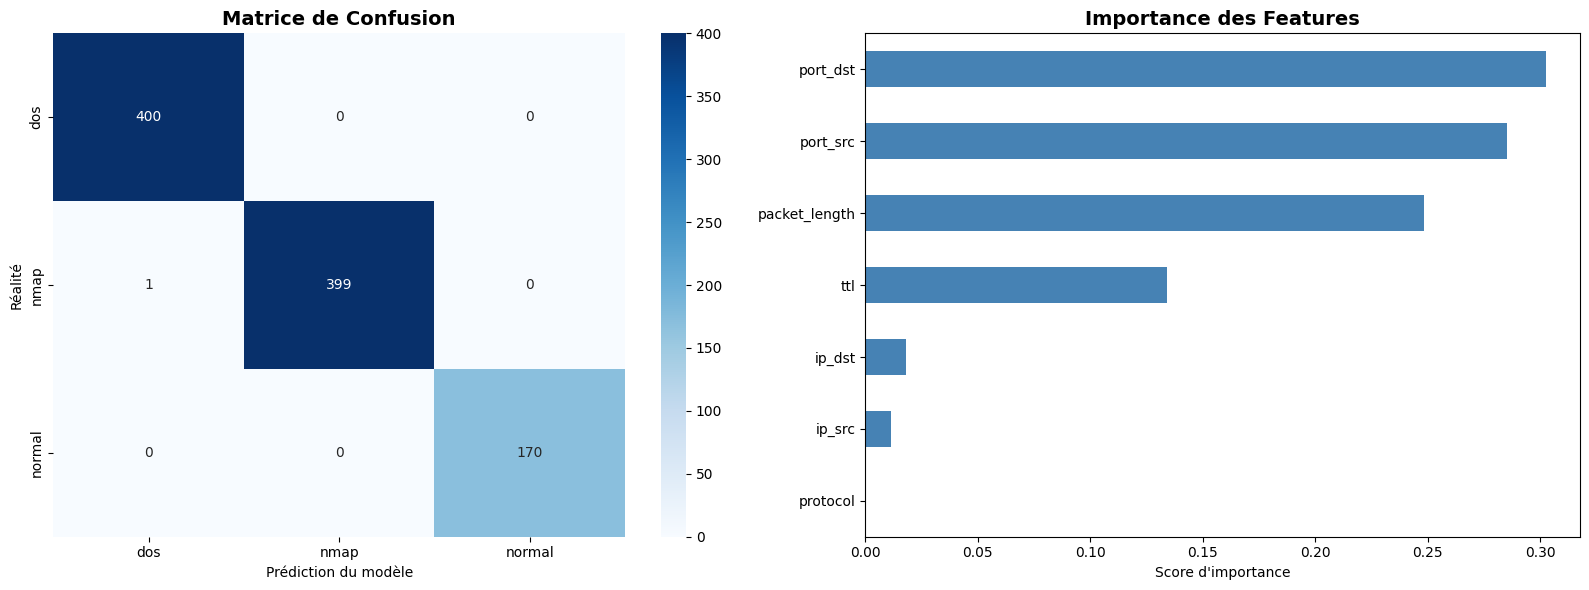


Graphiques sauvegardés dans E:\IDS_Project\resultats_ids.png


In [7]:
# Rapport de classification

y_pred = model.predict(X_test)

print("RAPPORT DE CLASSIFICATION")
print("="*50)
print(classification_report(
    y_test, y_pred,
    target_names=le_label.classes_
))


# Matrice de confusion

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1 : Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le_label.classes_,
    yticklabels=le_label.classes_,
    ax=axes[0]
)
axes[0].set_title('Matrice de Confusion', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Réalité')
axes[0].set_xlabel('Prédiction du modèle')

# Graphique 2 : Importance des features
importances = pd.Series(
    model.feature_importances_,
    index=features
).sort_values(ascending=True)

importances.plot(
    kind='barh',
    ax=axes[1],
    color='steelblue'
)
axes[1].set_title('Importance des Features', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Score d\'importance')

plt.tight_layout()
plt.savefig(r"E:\IDS_Project\resultats_ids.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nGraphiques sauvegardés dans E:\\IDS_Project\\resultats_ids.png")

In [16]:
# Simulateur de détection en temps réel
# et demande d'avis à l'IA

def analyser_paquet(protocol, ip_src, ip_dst, port_src, port_dst, packet_length, ttl):
    
    # Encodage des valeurs texte comme à l'entraînement
    try:
        proto_encoded = le_protocol.transform([str(protocol)])[0]
    except:
        proto_encoded = 0

    try:
        src_encoded = le_src.transform([str(ip_src)])[0]
    except:
        src_encoded = 0

    try:
        dst_encoded = le_dst.transform([str(ip_dst)])[0]
    except:
        dst_encoded = 0

    # Construction du paquet sous forme de tableau
    paquet = [[proto_encoded, src_encoded, dst_encoded,
               port_src, port_dst, packet_length, ttl]]

    # Demande à l'IA sa prédiction
    prediction = model.predict(paquet)[0]
    label_predit = le_label.inverse_transform([prediction])[0]

    # Récupération des probabilités et niveau de confiance en %
    probas = model.predict_proba(paquet)[0]
    confiance = max(probas) * 100

    # Choix selon le verdict
    if label_predit == 'normal':
        danger = "AUCUN"
    elif label_predit == 'nmap':
        danger = "MOYEN — Scan de ports détecté"
    else:
        danger = "CRITIQUE — Attaque DoS détectée"

    print(f"VERDICT : {label_predit.upper()}")
    print(f"   Niveau de danger  : {danger}")
    print(f"   Confiance de l'IA : {confiance:.1f}%")
    print(f"   Détail des probabilités :")
    for classe, proba in zip(le_label.classes_, probas):
        barre = "█" * int(proba * 20)
        print(f"      {classe:<8} : {barre:<20} {proba*100:.1f}%")
    print()

print("Fonction de détection prête")

Fonction de détection prête


In [17]:
# ============================================================
# SCÉNARIO 1 : Trafic normal
# Un administrateur se connecte en SSH à un serveur
# SSH utilise le port 22, paquet de taille normale
# ============================================================

print("="*55)
print("SCÉNARIO 1 : Connexion SSH d'un administrateur")
print("="*55)
analyser_paquet(
    protocol      = "TCP",
    ip_src        = "192.168.100.20",
    ip_dst        = "192.168.100.10",
    port_src      = 52341,   # port aléatoire côté client
    port_dst      = 22,      # port SSH
    packet_length = 512,     # taille normale
    ttl           = 64       # TTL Linux standard
)

# ============================================================
# SCÉNARIO 2 : Scan Nmap
# Un attaquant teste les ports 1 à 1000 rapidement
# Petits paquets SYN vers des ports séquentiels
# ============================================================

print("="*55)
print("SCÉNARIO 2 : Scan de ports Nmap")
print("="*55)
analyser_paquet(
    protocol      = "TCP",
    ip_src        = "192.168.100.20",
    ip_dst        = "192.168.100.10",
    port_src      = 44321,
    port_dst      = 445,     # port SMB souvent scanné
    packet_length = 44,      # très petit paquet SYN
    ttl           = 45       # TTL réduit après plusieurs sauts
)

# ============================================================
# SCÉNARIO 3 : Attaque DoS SYN Flood Problématique
# Des milliers de minuscules paquets arrivent d'un coup
# ============================================================

print("="*55)
print("SCÉNARIO 3 : Attaque DoS SYN Flood Problématique")
print("="*55)
analyser_paquet(
    protocol      = "TCP",
    ip_src        = "192.168.100.20",
    ip_dst        = "192.168.100.10",
    port_src      = 12345,
    port_dst      = 80,      # vise le serveur web
    packet_length = 64,      # paquet minuscule typique du flood
    ttl           = 128      # TTL Windows
)

# ============================================================
# SCÉNARIO 4 : Vrai Attaque DoS SYN Flood
# Des milliers de minuscules paquets arrivent d'un coup
# ============================================================

print("="*55)
print("SCÉNARIO 4 : Vrai Attaque DoS SYN Flood")
print("="*55)
analyser_paquet(
    protocol      = "TCP",
    ip_src        = "192.168.100.20",
    ip_dst        = "192.168.100.10",
    port_src      = 2309,    # séquentiel comme hping3
    port_dst      = 0,       # signature hping3 flood
    packet_length = 60,      # taille hping3 réelle capturée
    ttl           = 64       # TTL Kali
)

# ============================================================
# SCÉNARIO 5 : Cas ambigu — l'IA doute-t-elle ?
# Paquet avec des caractéristiques mixtes
# ============================================================

print("="*55)
print("SCÉNARIO 5 : Cas ambigu (caractéristiques mixtes)")
print("="*55)
analyser_paquet(
    protocol      = "TCP",
    ip_src        = "192.168.100.20",
    ip_dst        = "192.168.100.10",
    port_src      = 33333,
    port_dst      = 8080,
    packet_length = 128,     # ni trop petit ni trop grand
    ttl           = 60       # TTL intermédiaire
)


SCÉNARIO 1 : Connexion SSH d'un administrateur
VERDICT : NORMAL
   Niveau de danger  : AUCUN
   Confiance de l'IA : 94.0%
   Détail des probabilités :
      dos      : █                    5.0%
      nmap     :                      1.0%
      normal   : ██████████████████   94.0%

SCÉNARIO 2 : Scan de ports Nmap
VERDICT : NMAP
   Niveau de danger  : MOYEN — Scan de ports détecté
   Confiance de l'IA : 89.0%
   Détail des probabilités :
      dos      : █                    8.0%
      nmap     : █████████████████    89.0%
      normal   :                      3.0%

SCÉNARIO 3 : Attaque DoS SYN Flood Problématique
VERDICT : NORMAL
   Niveau de danger  : AUCUN
   Confiance de l'IA : 84.0%
   Détail des probabilités :
      dos      : █                    7.0%
      nmap     : █                    9.0%
      normal   : ████████████████     84.0%

SCÉNARIO 4 : Vrai Attaque DoS SYN Flood
VERDICT : DOS
   Niveau de danger  : CRITIQUE — Attaque DoS détectée
   Confiance de l'IA : 100.0%
   Dét

In [11]:
dos_reel = df[df['label'] == 'dos'].head(10)
print("Caractéristiques réelles de tes paquets DoS :")
print(dos_reel[['protocol', 'port_src', 'port_dst', 
                 'packet_length', 'ttl']].to_string())

Caractéristiques réelles de tes paquets DoS :
     protocol  port_src  port_dst  packet_length  ttl
2847      TCP      2309         0             60   64
2848      TCP      2310         0             60   64
2849      TCP      2311         0             60   64
2850      TCP      2312         0             60   64
2851      TCP      2313         0             60   64
2852      TCP      2314         0             60   64
2853      TCP      2315         0             60   64
2854      TCP      2316         0             60   64
2855      TCP         0      2309             54   64
2856      TCP         0      2310             54   64


In [13]:
# Analyse critique du modèle

print("""
LIMITES IDENTIFIÉES DU MODÈLE

1. OVERFITTING SUR LES IPs
   Le modèle a appris les adresses IP spécifiques du labo
   (192.168.100.x). Il échoue sur des IPs inconnues.
        Solution : supprimer ip_src/ip_dst des features
        et ajouter des features comportementales (débit,
        inter-arrival time...)

2. DATASET PEU DIVERSIFIÉ
   Un seul outil DoS (hping3), un seul scanner (nmap),
   depuis une seule machine.
        Solution pro : utiliser des datasets publics comme
        CICIDS2017 qui contient des dizaines d'attaques
        différentes.

3. FEATURES LIMITÉES
   On n'analyse qu'un paquet à la fois.
   Un vrai IDS analyse des flux.
        C'est ce que fait CICFlowMeter avec 80+ features par flux.
""")


LIMITES IDENTIFIÉES DU MODÈLE

1. OVERFITTING SUR LES IPs
   Le modèle a appris les adresses IP spécifiques du labo
   (192.168.100.x). Il échoue sur des IPs inconnues.
        Solution : supprimer ip_src/ip_dst des features
        et ajouter des features comportementales (débit,
        inter-arrival time...)

2. DATASET PEU DIVERSIFIÉ
   Un seul outil DoS (hping3), un seul scanner (nmap),
   depuis une seule machine.
        Solution pro : utiliser des datasets publics comme
        CICIDS2017 qui contient des dizaines d'attaques
        différentes.

3. FEATURES LIMITÉES
   On n'analyse qu'un paquet à la fois.
   Un vrai IDS analyse des flux.
        C'est ce que fait CICFlowMeter avec 80+ features par flux.



In [19]:
# Création d'un échantillon représentatif pour GitHub de
# 200 exemples de chaque classe
df_sample = pd.concat([
    df[df['label'] == 'normal'],              # tous (846)
    df[df['label'] == 'nmap'].sample(200, random_state=42),
    df[df['label'] == 'dos'].sample(200, random_state=42)
])

df_sample.to_csv(
    r"E:\IDS_Project\Datasets\dataset_sample.csv",
    index=False
)

print(f"Échantillon créé : {len(df_sample)} lignes")
print(f"   Taille estimée : ~90 Ko")

Échantillon créé : 1246 lignes
   Taille estimée : ~90 Ko
